# Brazilian Wind Farm Layout Optimization

In [5]:
import rasterio
from shapely.geometry import mapping
import os
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from rasterio import features
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
from pyproj import Transformer
from scipy.ndimage import uniform_filter
import elevation
import tempfile
import seaborn as sns
import osmnx as ox
import pyrosm
from src.utils import DATA_DIR, KILOMETERS_OFFSHORE

In [6]:
plt.style.use('dark_background')
# set font to serif
plt.rcParams["font.family"] = "serif"

In [7]:
# topography = gdal.Open('data/topography/brazil_dem.tif')
# topography_array = topography.ReadAsArray().astype(np.float32)

In [8]:
def compute_slope(topography):
    # efficient slope calculation
    nodata = topography.min()
    topography[topography == nodata] = np.nan
    slope = np.sqrt(np.square(np.gradient(topography, axis=0)) + np.square(np.gradient(topography, axis=1)))
    return slope

def compute_roughness(topography):
    # efficient roughness calculation
    nodata = topography.min()
    topography[topography == nodata] = np.nan
    roughness = np.abs(np.gradient(np.gradient(topography, axis=0), axis=0)) + np.abs(np.gradient(np.gradient(topography, axis=1), axis=1))
    return roughness

#

# compute_slope(topography_array[::5, ::5]).shape
# plot_raster(compute_slope(topography_array[::50, ::50][:200, 170:500]).round(2)), plot_raster(compute_roughness(topography_array[::50, ::50][:200, 170:500]).round(2))

In [9]:
# make slope.tif from brazil_dem.pbf
# topography = gdal.Open(f"{DATA_DIR}/topography/brazil_dem.tif")
# 
# roughness = gdal.DEMProcessing(f"{DATA_DIR}/topography/roughness.tif", topography, 'roughness')
# roughness = None
# 
# slope = gdal.DEMProcessing(f"{DATA_DIR}/topography/slope.tif", topography, 'slope')
# slope = None
# 
# topography = None

In [10]:
def plot_raster(raster):
    fig, ax = plt.subplots(figsize=(10, 10))

    if raster.shape[0] > 10000:
        img = raster[::100, ::100]

    elif raster.shape[0] > 1000:
        img = raster[::10, ::10]
    else:
        img = raster
    raster_masked = np.ma.masked_where(img == -9999, img)
    # normalize the data
    ax.imshow(raster_masked, cmap='gray')  # Apply a color map if desired
    return ax

## load data

In [11]:
def load_vector(fp):
    df = pd.read_csv(f'{DATA_DIR}/{fp}')
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
    return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

In [12]:
def load_raster(fp, area=None):
    """
    Loads raster data and crops it to the area of interest.
    """
    if fp.startswith('topography'):
        dataset = gdal.Open(f"{DATA_DIR}/{fp}")
        array = dataset.ReadAsArray()
        dataset = None
        with rasterio.open(f"{DATA_DIR}/{fp}") as src:
            transform = src.transform
            metadata = src.meta
            nodata = src.nodatavals[0]
        return {'array': array, 'transform': transform, 'metadata': metadata, 'nodata': nodata}
    else:
        geometry = [mapping(polygon) for polygon in area.geometry]
        with rasterio.open(f"{DATA_DIR}/{fp}") as src:
            out_image, out_transform = rasterio.mask.mask(src, geometry, crop=True)
            out_image = out_image[0].astype('float32')
            out_image[out_image < 0] = np.nan
            out_meta = src.meta
            nodata = src.nodatavals[0]
            out_meta['height'] = out_image.shape[0]
            out_meta['width'] = out_image.shape[1]
            return {'array': out_image, 'transform': out_transform, 'metadata': out_meta, 'nodata': nodata}

In [13]:
def buffer_geometry(geometry, distance):
    """
    Buffer a polygon by a given distance.
    """
    return geometry.to_crs('EPSG:3857').buffer(distance * 1000).to_crs('EPSG:4326')

def geometry_raster(geometry, raster):
    """
    Create a raster from a geometry.
    """
    return features.rasterize(
        [(geom, 1) for geom in geometry],
        out_shape=raster['array'].shape,
        transform=raster['transform'],
        fill=0,
        all_touched=True,
        dtype=np.uint8,
    )

In [14]:
def scale_and_crop_raster(source, target):
    dest_array = np.empty(target['array'].shape, dtype='float32')

    # Perform the reprojection
    reproject(
        source=source['array'],
        destination=dest_array,
        src_transform=source['transform'],
        src_crs=source['metadata']['crs'],
        dst_transform=target['transform'],
        dst_crs=target['metadata']['crs'],
        resampling=Resampling.nearest
    )

    return dest_array

def scale_data_helper(source, target):
    source['array'] = scale_and_crop_raster(source, target)
    source['transform'] = target['transform']
    return source

    

def scale_data(data, scale='small'):
    if scale == 'large':
        data['power_density'] = scale_data_helper(data['power_density'], data['topography'])
        data['wind_speed'] = scale_data_helper(data['wind_speed'], data['topography'])
        data['population'] = scale_data_helper(data['population'], data['topography'])
    if scale == 'mid':
        data['population'] = scale_data_helper(data['population'], data['wind_speed'])
        data['topography'] = scale_data_helper(data['topography'], data['wind_speed'])
        data['slope'] = scale_data_helper(data['slope'], data['wind_speed'])
        data['roughness'] = scale_data_helper(data['roughness'], data['wind_speed'])
    if scale == 'small':
        data['slope'] = scale_data_helper(data['slope'], data['population'])
        data['topography'] = scale_data_helper(data['topography'], data['population'])
        data['roughness'] = scale_data_helper(data['roughness'], data['population'])
        data['power_density'] = scale_data_helper(data['power_density'], data['population'])
        data['wind_speed'] = scale_data_helper(data['wind_speed'], data['population'])
    return data 

In [15]:
brazil = ox.geocode_to_gdf('Brazil').to_crs(epsg=3857).to_crs(epsg=4326).geometry
polygons = [p for p in brazil.iloc[0].geoms]
brazil = polygons[np.argmax([p.area for p in polygons])]
brazil = gpd.GeoDataFrame({'geometry': [brazil]}, crs='EPSG:4326').geometry
brazil_and_buffer = brazil.to_crs(epsg=3857).buffer(80 * 1000).to_crs(epsg=4326)
buffer = brazil_and_buffer.difference(brazil)
neighbours = [ox.geocode_to_gdf(n).to_crs(epsg=4326) for n in ['French Guiana', 'Suriname', 'Guyana', 'Venezuela', 'Colombia', 'Peru', 'Bolivia', 'Paraguay', 'Uruguay', 'Argentina']]
neighbours = gpd.GeoDataFrame(pd.concat(neighbours, ignore_index=True)).geometry.unary_union
brazil_and_offshore = brazil_and_buffer.difference(neighbours)
# get largest polgyon
brazil_and_offshore = gpd.GeoDataFrame({'geometry': [brazil_and_offshore[np.argmax([p.area for p in brazil_and_offshore])]]}, crs='EPSG:4326').geometry
offshore = brazil_and_offshore.difference(brazil)
# offshore is buffer, with areas in other countries removed

In [16]:
raster_fps = {'power_density': 'meterology/gwa3_250_powerdensity_100m.tif', 'wind_speed': 'meterology/gwa3_250_windspeed_100m.tif',
        'population': 'demography/bra_pd_2020_1km.tif', 'topography': 'topography/brazil_dem.tif',
        'slope': 'topography/slope.tif', 'roughness': 'topography/roughness.tif'}

raster_data = scale_data({k: load_raster(v, brazil_and_offshore) for k, v in raster_fps.items()}, 'small') if 'data' not in locals() else eval('raster_data')

In [17]:
brazil_mask = geometry_raster(brazil, raster_data['population'])
offshore_mask = geometry_raster(offshore, raster_data['population'])
brazil_and_offshore_mask = geometry_raster(brazil_and_offshore, raster_data['population'])

### vector data

In [18]:
vector_fps = [f for f in os.listdir(f'{DATA_DIR}/infrastructure') if f.endswith('.csv')]
vector_data = {f.split('.')[0]: load_vector(f'infrastructure/{f}') for f in vector_fps}

In [19]:
power_line_mask = geometry_raster(buffer_geometry(vector_data['power_lines'], 16), raster_data['population'])
airport_mask = geometry_raster(buffer_geometry(vector_data['airports'], 6), raster_data['population'])
protected_areas_mask = geometry_raster(vector_data['protected_areas'].geometry, raster_data['population'])

## process data

In [20]:
def get_percentile(raster, percentile):
    array = raster['array']
    nodata = raster['nodata']
    # Calculate the percentile of a raster.
    return np.nanpercentile(array[array != nodata], percentile)

In [21]:
rougness_limit = get_percentile(raster_data['roughness'], 30)
slope_limit = get_percentile(raster_data['slope'], 30)
power_density_limit = get_percentile(raster_data['power_density'], 80)

In [25]:
power_density_mask = raster_data['power_density']['array'] > power_density_limit
roughness_mask = (raster_data['roughness']['array'] > rougness_limit) & brazil_mask
wind_speed_mask = (raster_data['wind_speed']['array'] > 7) & brazil_and_offshore_mask
slope_mask = (raster_data['slope']['array'] > slope_limit) & brazil_mask
# topography_mask = (raster_data['topography']['array'].astype(float)) & brazil_mask
# base
M = np.ones_like(raster_data['topography']['array'])

# account for no data
M[brazil_and_offshore_mask == 0] = 0

# account for roughness
M[(raster_data['roughness']['array'] > rougness_limit)] = 0

# account for slope
# M[(raster_data['slope']['array'] > slope_limit)] = 0

# account for power density (between 0 and 10)
M[(raster_data['power_density']['array'] < power_density_limit)] = 0

# account for wind speed off shore
M[(offshore_mask == 1) & (wind_speed_mask == 0)] = 0

# account for proximity to powerline (in power line mask)
M[(power_line_mask == 1)] = 0

# account for protected areas
M[(protected_areas_mask == 1)] = 0

# account for airports
M[(airport_mask == 1)] = 0
# cacing masks
np.save(f'./masks/brazil_mask.npy', brazil_mask)
np.save(f'./masks/offshore_mask.npy', offshore_mask)
np.save(f'./masks/brazil_and_offshore_mask.npy', brazil_and_offshore_mask)
np.save(f'./masks/power_density_mask.npy', power_density_mask)
np.save(f'./masks/roughness_mask.npy', roughness_mask)
np.save(f'./masks/wind_speed_mask.npy', wind_speed_mask)
np.save(f'./masks/slope_mask.npy', slope_mask)
np.save(f'./masks/power_line_mask.npy', power_line_mask)
np.save(f'./masks/airport_mask.npy', airport_mask)
np.save(f'./masks/protected_areas_mask.npy', protected_areas_mask)
np.save(f'./masks/M.npy', M)

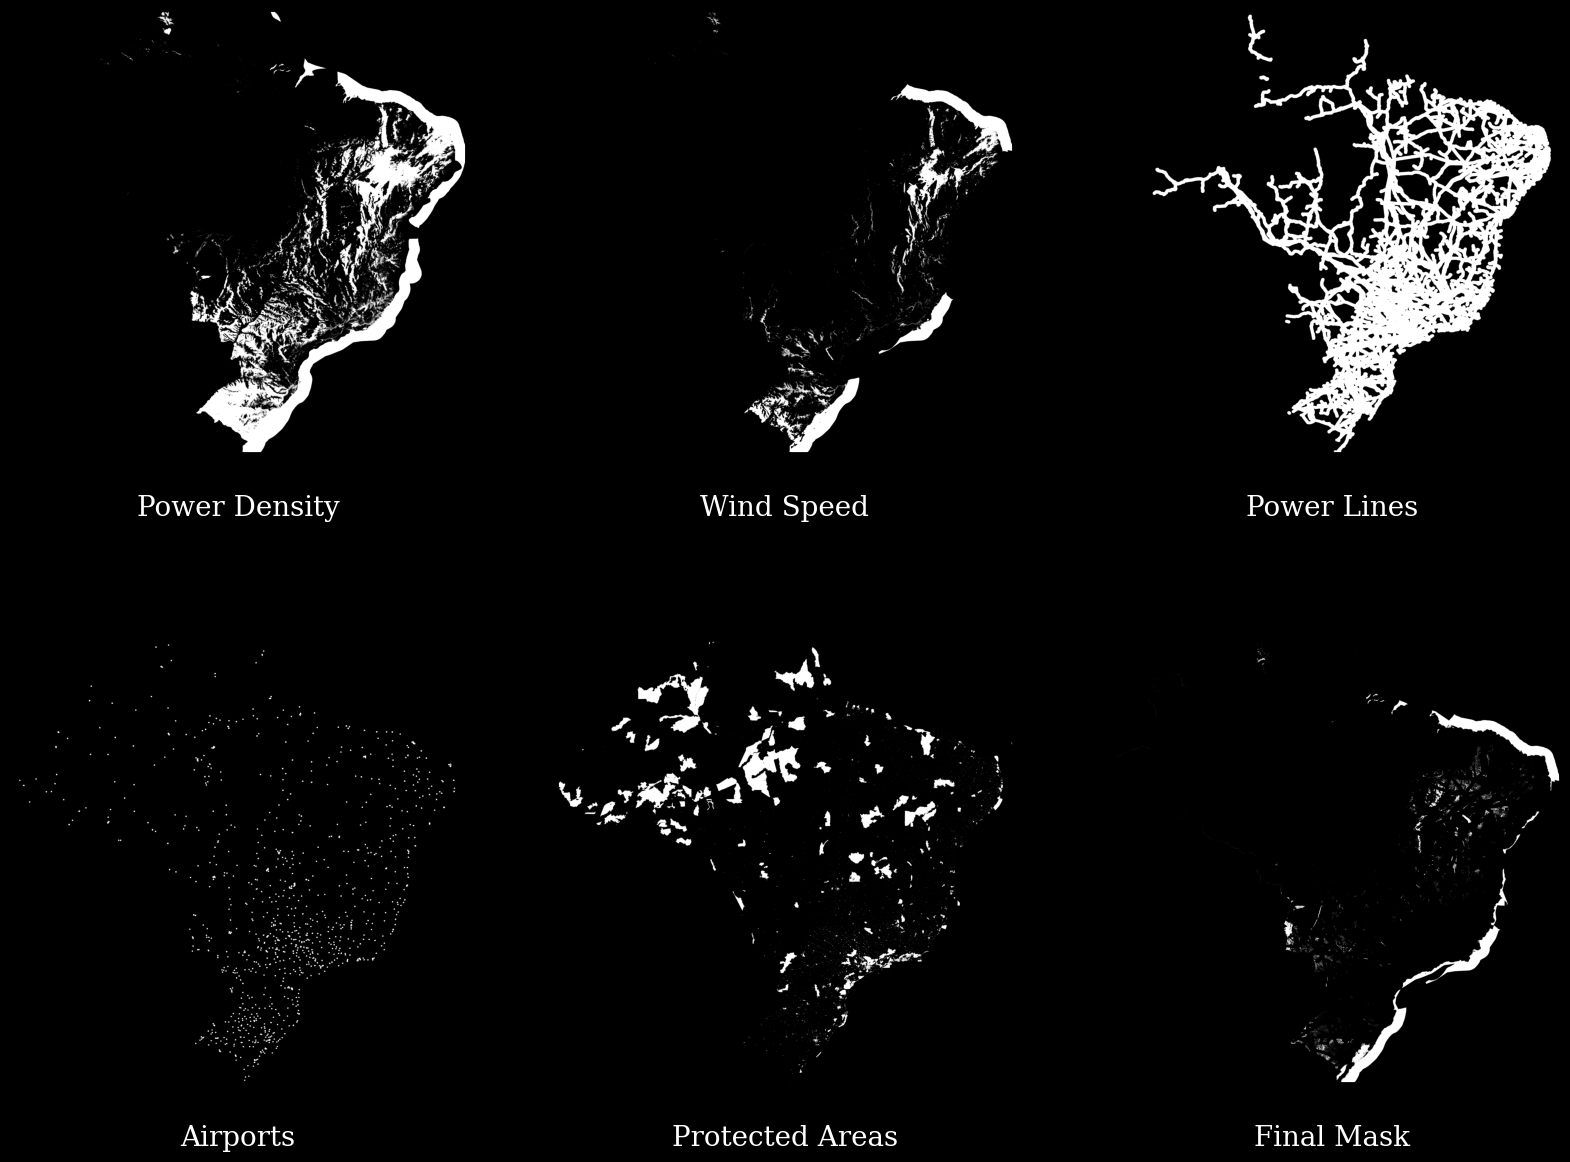

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
for ax, mask, title in zip(axes.flatten(),
    [power_density_mask, wind_speed_mask, power_line_mask, airport_mask, protected_areas_mask, M],
    ['Power Density', 'Wind Speed', 'Power Lines', 'Airports', 'Protected Areas', 'Final Mask']):
    ax.imshow(mask, cmap='gray')
    # add title below each image. Add some padding above title.
    ax.set_xlabel(title, fontsize=20, labelpad=30)
    ax.set_xticks([])
    ax.set_yticks([])
    # make border black
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(2)
# plt.savefig('figures/mask.png', bbox_inches='tight', dpi=300)
plt.show()